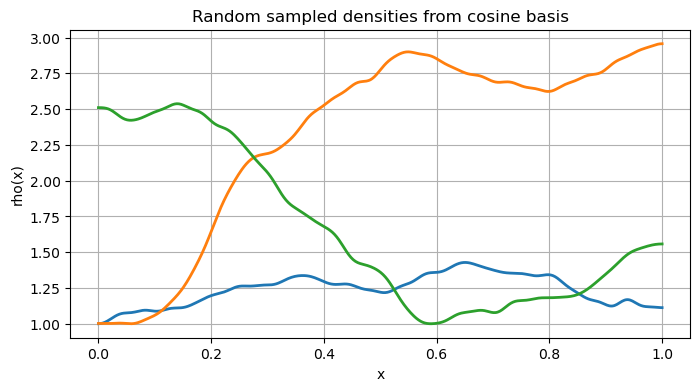

tensor([1427.9187, 4149.7495, 2412.8540, 2163.3779, 2777.4395, 2422.1831,
        1764.9786, 3231.8044, 3006.4463, 3247.8567, 2223.6184, 2523.5247,
        2406.1594, 1422.7747, 1805.6512, 2949.9316, 1302.5083, 1759.9814,
        1826.1228, 1401.8323, 2876.0544, 2089.2490, 1825.8273, 1794.5533,
        2515.2300, 1918.1704, 2195.0991, 1290.6202, 2023.6412, 2114.1179,
        1783.3486, 4124.0771])

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float32
device = "cpu"

M_cutoff = 50 # maximum harmonic
N_grid   = 512
m = torch.arange(1, M_cutoff+1, dtype=dtype, device=device)             # (M,)
x = torch.linspace(0, 1, N_grid, dtype=dtype, device=device)            # (N,)
#design matrix needed to sample densities
DesignMatrix = torch.cos(torch.pi * torch.outer(m, x))                  # (M, N)
std_harm = 2.0 / (1.0 + m)**2

N_train = 1000
N_test = 200

N_batch = 32
N_epochs = 500
lr = 1e-3

def sample_density(*, rho_b=1.0):
    """
    Sample rho_j = rho_avg + sum_{m=1}^M a_m cos(m pi x_j), with x_j in [0,1]
    this sampling of amplitudes a_m implies that the derivatives at the boundaries are zero
    Sampling is done such that the generated density is non-negative everywhere

    Returns:
      rho : (N,) density profile
    """    
    a = torch.normal(torch.zeros_like(std_harm), std_harm)
    rho = a @ DesignMatrix                            

    rho = rho - rho.min() + rho_b                           # make non-negative
    return rho

def sample_density_batch(B: int, rho_b=1.0):
    """
    Sample a batch of B density profiles.
    Returns rho: (B, N_grid)
    """
    a = torch.normal(torch.zeros(B, std_harm.numel()), std_harm.expand(B, -1))
    rho = a @ DesignMatrix    # (B, N_grid)

    rho_min = rho.min(dim=1, keepdim=True).values
    rho = rho - rho_min + rho_b
    return rho

def E_tot(rho: torch.Tensor) -> torch.Tensor:
    """
    Compute E_tot -- custom functional
    rho: (N,) or (B, N)
    Returns: scalar (if input 1D) or (B,) (if input 2D)
    """
    return (rho + rho**2).sum(dim=-1)

# generate one sample
rho_batch = sample_density_batch(32)  # (B, N_grid)

# plot
plt.figure(figsize=(8,4))
plt.plot(x.numpy(), rho_batch[0, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[1, :].numpy(), lw=2)
plt.plot(x.numpy(), rho_batch[2, :].numpy(), lw=2)
plt.xlabel("x")
plt.ylabel("rho(x)")
plt.title("Random sampled densities from cosine basis")
plt.grid(True)
plt.show()


E_tot(rho_batch)  # (B,)


In [47]:
# we save features as (B, N_grid, N_feat), where N_feat=1 for now
features = rho_batch.unsqueeze(-1)  # (B, N_grid, 1)
targets  = E_tot(rho_batch)         # (B,)

# generate train/test split
rho_train = sample_density_batch(N_train)  # (N_train, N_grid)
rho_test  = sample_density_batch(N_test)   # (N_test, N_grid)
features_train = rho_train.unsqueeze(-1)
features_test = rho_test.unsqueeze(-1)
targets_train = E_tot(rho_train)            # (N_train,)
targets_test  = E_tot(rho_test)             # (N_test,) 

In [48]:
# Define the neural network models
class LocalEngDensityNN(nn.Module):
    """
    A neural network for predicting energy density from a local feature vector.
    """
    def __init__(self, N_feat=1, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(N_feat, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1) # output is a scalar energy density
        )
    
    def forward(self, features):
        # features: (B, N_grid, N_feat)
        output = self.net(features)
        return output.squeeze(-1)
    
class TotalEnergyNN(nn.Module):
    def __init__(self, N_feat=1, hidden_dim=128):
        super().__init__()
        self.local_energy_net = LocalEngDensityNN(N_feat, hidden_dim)
        
    def forward(self, features):
        """
        Args:
            features: (B, N_grid, N_feat)
        
        Returns:
            local_energies: (B, N_grid) - energy at each grid point
            total_energy: (B,) - sum over grid points
        """
        local_energies = self.local_energy_net(features)  # (B, N_grid)
        total_energy = local_energies.sum(dim=1)          # (B,)
        
        return local_energies, total_energy

In [49]:
#model training

model = TotalEnergyNN(N_feat=1)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_dataset = TensorDataset(features_train, targets_train)
train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True)

# Training loop
for epoch in range(N_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_features, batch_targets in train_loader:
        optimizer.zero_grad()

        local_pred, total_pred = model(batch_features)
        loss = criterion(total_pred, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.6f}")


Epoch 10, Loss: 7682.747395
Epoch 20, Loss: 2050.101036
Epoch 30, Loss: 654.457839
Epoch 40, Loss: 364.251184
Epoch 50, Loss: 204.876329
Epoch 60, Loss: 149.820278
Epoch 70, Loss: 124.101495
Epoch 80, Loss: 111.304918
Epoch 90, Loss: 107.068413
Epoch 100, Loss: 50.684260
Epoch 110, Loss: 101.941565
Epoch 120, Loss: 69.906634
Epoch 130, Loss: 54.398269
Epoch 140, Loss: 32.076540
Epoch 150, Loss: 32.615518
Epoch 160, Loss: 30.138212
Epoch 170, Loss: 21.578146
Epoch 180, Loss: 22.022246
Epoch 190, Loss: 121.379528
Epoch 200, Loss: 6.634820
Epoch 210, Loss: 378.917865
Epoch 220, Loss: 390.903485
Epoch 230, Loss: 13.830137
Epoch 240, Loss: 27.669527
Epoch 250, Loss: 62.675066
Epoch 260, Loss: 4.221123
Epoch 270, Loss: 15.339107
Epoch 280, Loss: 8.284763
Epoch 290, Loss: 1357.407084
Epoch 300, Loss: 25.231646
Epoch 310, Loss: 8.754969
Epoch 320, Loss: 8.846276
Epoch 330, Loss: 4.199772
Epoch 340, Loss: 11.570020
Epoch 350, Loss: 721.203837
Epoch 360, Loss: 6.894146
Epoch 370, Loss: 406.26564

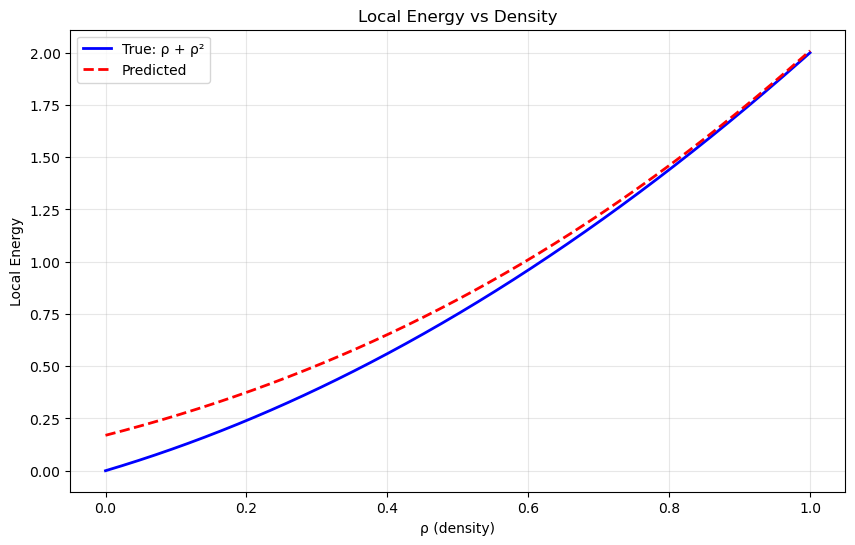

In [50]:
rho_test = x.unsqueeze(-1).unsqueeze(0)  # (1, N_grid, 1)
loc_energy_dens = rho_test + rho_test**2

local_pred, total_pred = model(rho_test)

# Plotting
rho_values = rho_test.squeeze().detach().numpy()  # (N_grid,)
true_local = loc_energy_dens.squeeze().detach().numpy()  # (N_grid,)
pred_local = local_pred.squeeze().detach().numpy()  # (N_grid,)

plt.figure(figsize=(10, 6))
plt.plot(rho_values, true_local, 'b-', linewidth=2, label='True: ρ + ρ²')
plt.plot(rho_values, pred_local, 'r--', linewidth=2, label='Predicted')
plt.xlabel('ρ (density)')
plt.ylabel('Local Energy')
plt.title('Local Energy vs Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
